In [1]:
# version control
# revise on: blog-PCA-part I_siyun_0513.ipynb
# revise on: blog-PCA-part I_kefei_0616.ipynb

# package use:
# ...


# Preprocessing, Outliers, Categorical data. The stories of PCA you might not find in every textbook.
## Part I: Scalers and PCA

# Intro (of the series)
Welcome to our journey! We would like to explore the combinasion of scaling data and the PCA, to see how we can better prepare data for machine learning tasks whenever we come across a new dataset.  The journey is composed of three parts:

**Part I (this blog)**: Rescaling data before applying the PCA. As you've already known, PCA is sensible to the scale of a dataset, hence getting each feature to a reasonable scale is crucial to PCA.  In this part, we are going to see how different scalers can effect the PCA results.

**Part II**: Limits of our proposed combinasion. How the scalers react to outliers? What happens if we are to apply PCA naively onto dataset containing categorical features? Can some of the Sklearn-available scalers help to process categorical features to make them consistent with PCA's mechanism?

**Part III**: ...

# Part I: Scalers and PCA

## Outline of this post

 0. A brief introduction of the PCA
 1. What data scalers are used for
 2. Here come the tests, using the wine dataset
> 2.0 about the data we will use <br>
> 2.1 about the task <br>
> 2.2 explortary data analysis <br>
> 2.3 comparaison of different scalers <br>

 3. Summary

This post is inspired by this [tutorial](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py) from Scikit-Learn's document. You will see us testing different scalers using the same wine dataset, and passing the differently scaled data to the PCA step. This little toy set demonstrate the power of the combinasion of scaler + PCA, perhaps you would like to have it in your own tool box.

## 0. A brief introduction of the PCA
Before diving into more details, we would like to make a brief introduction about the PCA, for the sake of completeness of our journey. For readers who have already understood the maths behind, feel free to jump directly to the next section.

PCA is the abbreviation of "principal component analysis", one of its main functionalities is to reduce the dimension (columns) of a dataset. This is done by [singular value decompsition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) of linear algebra. Intuitively, data are represented in form of a matrix, whose columns are axis of a high dimensional space. Data points represented with such axis are somtimes hard for machine learning models to explore. What SVD does is to find a smarter representation of the dataset (by linear combinasion of the original axis), such that the data expressed by the new abstract axis are more model-friendly. 

A few more words on the new set of axis: they are mutually orthogonal (even better, orthonormal). This property can be particularly lovely for tree-based models. The new set of axis are ordered by the ability of representing the dataset's information or variability, hence the functinality of dimensinality reduction, mentioned above: one can retain large amount of information by using only the first few axis from PCA. 

## 1. Data scalers
Imagine a dataset of house prices, containing features like the number of rooms, the area and the price of the apartments. The variability of these three columns are of great difference: the maximum difference of the number of rooms can hardly exceed 10 rooms, that is of order 1; while the maximum difference of the area of an apartment can be of order 100 squared-feet, let alone the variance in the prices, which reaches easily the order 10K. 

If we are to apply PCA on such a dataset whose variability of columns differs in order, the effect of those relatively "smooth" features will be totally overwhelmed by the most furious one (the price in this example). To remedy the problem, we scale the data.

There are a bunch of different scalers available with one-line code in SciKit-Learn, like the most commonly used standard scaler and min-max scaler, and other non-linear scalers. In this blog post we are interested in testing all these available scalers before applying PCA, and see how they act with PCA. 

Here is a detailed and beautiful [demonstration](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py) of all scalers tested in this post.

## 2. Bring the tests on!
Let's dive in. First we will need some preparation codes.

In [2]:
# load packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,QuantileTransformer,RobustScaler,Normalizer,MaxAbsScaler,MinMaxScaler,PowerTransformer
from sklearn.datasets import load_wine

RANDOM_STATE = 2020

In [3]:
print(sns.__version__)
print(sklearn.__version__)
print(pd.__version__)

0.10.1
0.22.1
1.0.3


In [4]:
# customer palette for visulization color code
customer_palette = sns.color_palette('Set1', 3)
customer_palette.append(sns.xkcd_palette(['greyish'])[0])

plt.rc('figure', facecolor='w')

In [5]:
def transformer_bundle(X_train, is_full_compare=True, is_get_instance=False):
    if is_full_compare:
        transformer_dict = {'StandardScaler': StandardScaler(), 
                            'QuantileTransformer':QuantileTransformer(), 
                            'RobustScaler':RobustScaler(), 
                            'Normalizer':Normalizer(), 
                            'MaxAbsScaler':MaxAbsScaler(), 
                            'MinMaxScaler':MinMaxScaler(), 
                            'PowerTransformer':PowerTransformer()}
    else:
        transformer_dict = {'StandardScaler': StandardScaler(), 
                            'QuantileTransformer':QuantileTransformer(), 
                            'PowerTransformer':PowerTransformer()}
    
    X_train_trans_dict = {trs:transformer_dict[trs].fit_transform(X_train) for trs in transformer_dict.keys()} 
    X_train_trans_dict['NoTransformer'] = X_train.values
    
    X_train_pca_dict = {trs:PCA().fit_transform(X_train_trans_dict[trs]) for trs in transformer_dict.keys()}
    X_train_pca_dict['NoTransformer'] = PCA().fit_transform(X_train)
    
    instance_pca_dict = {trs:PCA().fit(X_train_trans_dict[trs]) for trs in transformer_dict.keys()}
    instance_pca_dict['NoTransformer'] = PCA().fit(X_train)
    
    if not is_get_instance:
        return X_train_trans_dict, X_train_pca_dict
    else:
        return X_train_trans_dict, X_train_pca_dict, instance_pca_dict

In [6]:
def pca_scatter_plot(X_pca_dict, y, highlight_list=None):
    y = np.array(y)
    labels=['\nlabel few missing', '\nlabel half missing', '\nlabel all missing']
#     fig = plt.figure(figsize=(4*3,3*8), )
#     G = plt.GridSpec(nrows=len(X_pca_dict.keys()), ncols=3)
    fig, axes = plt.subplots(nrows=len(X_pca_dict.keys()), ncols=3, figsize=(4*3,3*len(X_pca_dict.keys())), sharey='row')
    for i in range(len(X_pca_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]
        
        # if there are some dots to be highlighted..        
        if highlight_list is not None:
            style_list = np.array(['original']*X.shape[0])
            style_list[highlight_list] = 'syn_oli'
        else:
            style_list=None
            
        for j in range(3):
#             this_ax = fig.add_subplot(G[i, j], sharey='row')
            this_ax = axes[i,j]
            # plot the first 2 components
            sns.scatterplot(data=None, x=X[:,0], y=X[:,1], 
                            hue=y[:,j], hue_order=[0,1,2,-1], 
                            style=style_list, 
                            alpha=0.6, palette=customer_palette, ax=this_ax)
            
            
            # set axis labels and title
            this_ax.set_xlabel('First component')
            this_ax.set_ylabel('Second component')
            this_ax.set_title(trs+labels[j], loc='left', fontsize='large')
            this_ax.legend(loc=2)
    plt.tight_layout(pad=0.5, )
    plt.show()

In [7]:
def pca_box_plot(X_pca_dict, y):
    y = np.array(y)
    ncols = list(X_pca_dict.values())[0].shape[1]
    nrows=len(X_pca_dict)
    
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols, sharey='row', figsize=(2*ncols,4*nrows))
    for i in range(len(X_pca_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]
        
        for j in range(ncols):
            this_ax = ax[i,j]
            # plot the first 2 components
            sns.boxplot(y=X[:,j], x=y, palette=customer_palette, ax=this_ax)
            # set axis labels and title
            this_ax.set_ylabel('Component No.%d' % j)
            if j == 0:
                this_ax.set_title(trs, loc='left', fontsize='x-large')                
#             this_ax.set_ylabel(this_ax.get_ylabel(), fontsize=15)
            # ax.set_xlabel(ax.get_xlabel(), fontsize=20)
            
#         plt.tight_layout()   
    plt.tight_layout(0.5)   
    plt.show()
    


In [8]:
# pca_box_plot(X_pca_dict, df_target.loc[:,'target_original'])

In [92]:
def pca_cluster_contour_plot(X_pca_dict, labels, kmeans):
    fig, axes = plt.subplots(nrows=len(X_pca_dict.keys()), ncols=1,figsize=(8*1,6*len(X_pca_dict.keys())))
    for i in range(len(X_pca_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]

        pred = kmeans.fit_predict(X[:,:2])    
        
        # relabel based on ground truth
        df_tmp = pd.concat([pd.DataFrame(X), labels.target_original, pd.DataFrame({'pred':pred})],axis = 1)
        df_tmp['pred'] = np.choose(pred,
                                   [df_tmp[df_tmp.pred==0].target_original.mode().values,
                                    df_tmp[df_tmp.pred==1].target_original.mode().values,
                                    df_tmp[df_tmp.pred==2].target_original.mode().values]).astype(np.int64)        

        ax = axes[i]
        for i in range(3):
            sns.kdeplot(data=df_tmp.iloc[:,0][df_tmp.pred==i], data2=df_tmp.iloc[:,1][df_tmp.pred==i],
                        shade=True,
                        color=sns.color_palette('Set1', desat=0.5)[i],
                        shade_lowest=False,
                        label='pred_'+str(i),
                        alpha=0.5,
                        ax=ax)
                   
        sns.scatterplot(x=df_tmp[df_tmp.target_original!=df_tmp.pred].iloc[:,0], 
                        y=df_tmp[df_tmp.target_original!=df_tmp.pred].iloc[:,1], 
                        color = 'orange',
                        marker= 'X',
                        s=150,
                        ax=ax, label='mismatch')

        sns.scatterplot(data=df_tmp, x=df_tmp.columns[0], y=df_tmp.columns[1], hue='target_original', palette='Set1',ax=ax, 
#                         label='none'
                       )
#         sns.scatterplot(data=df_tmp, x=df_tmp.columns[0], y=df_tmp.columns[1], hue=(df_tmp.target_original.astype('str').values), palette='Set1',ax=ax, 
# #                         label=['true_0','true_1,','true_2'], 
#                         legend=False,
#                        )
        ax.set_title(trs+'\nmismatch: {} (out of {})'.format(len(df_tmp[df_tmp.target_original!=df_tmp.pred]), len(df_tmp)),
                     loc='left', fontsize='x-large')
        ax.set_xlabel("1st PCA component")
        ax.set_ylabel("2nd PCA component")
#         ax.legend(loc='upper left')
        ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()

In [90]:
# # X_pca_dict
# x_pca_tmp = {key:X_pca_dict[key] for key in list(X_pca_dict.keys())[:2]}
# # x_pca_tmp

# pca_cluster_contour_plot(x_pca_tmp,y_train, kmeans)

In [10]:
def trans_heat_plot_abs(X_trans_dict, y_axis_labels):
    fig,ax = plt.subplots(nrows=len(X_trans_dict.keys()), ncols=1, sharey=True, figsize=(6,3*len(X_trans_dict.keys())))
    for i in range(len(X_trans_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_trans_dict)
        trs = list(X_trans_dict.keys())[ind]
        X = X_trans_dict[trs]
        
        y_axis_labels = df_features.columns
        
#         this_ax = ax[i,0]
        this_ax = ax[i]
        covmtrx = (np.cov(X.T))
        mask = np.triu(covmtrx,1)
        sns.heatmap(covmtrx, 
                    square=True,
                    mask = mask,
                    yticklabels=y_axis_labels,
                    center= 0,
#                     annot=True,
                    cmap=(sns.color_palette('RdBu_r',256)), #, 10
                    ax=this_ax,
           )
        this_ax.set_title(trs+str('(cov matrix)'),loc='left', fontsize='x-large')
        this_ax.set_xticklabels(this_ax.get_xticklabels(), rotation=0)
        
#         this_ax = ax[i,1]
# #         covmtrx = np.abs(np.cov(X.T))
#         covmtrx = (np.corrcoef(X.T))
#         mask = np.triu(covmtrx) -np.diag(np.diag(covmtrx))  
#         sns.heatmap(covmtrx, 
#                     square=True,
#                     mask = mask,
#                     yticklabels=y_axis_labels,
# #                     vmin= 0,
#                     center= 0,
# #                     cmap=(sns.color_palette('Greys',256)), #, 10
#                     cmap=(sns.color_palette('PuOr_r',10)), #, 10
#                     ax=this_ax,
#            )
#         this_ax.set_title(trs+str('(cc matrix)'),loc='left', fontsize='x-large')
#         this_ax.set_xticklabels(this_ax.get_xticklabels(), rotation=0)
        
    plt.tight_layout()        
    plt.show()

In [11]:
def pca_plot_cumsum(instance_pca_dict):


    trans_list_tmp = list(instance_pca_dict.keys())[-1:]+ list(instance_pca_dict.keys())[:-1]
    cumsum_list = [np.concatenate([[0],instance_pca_dict[trans].explained_variance_ratio_.cumsum()]) for trans in trans_list_tmp]
    
    df_cumsum = pd.DataFrame(np.array(cumsum_list).T)
    df_cumsum.columns = trans_list_tmp

    fig, ax = plt.subplots(1,1,figsize=(12,6), sharex=True, sharey=True)
    
    df_cumsum.plot(ax=ax, color=sns.color_palette('Accent'), kind='line', marker='o')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_ylabel('explained_variance_cumsum')
    ax.set_xlabel('PCA components')
    ax.set_xlim([0,len(cumsum_list[0])-0.5])
    ax.set_ylim([0,1.05])
#     ax.set_title(ax.get_title(),loc='left', fontsize='x-large')
    plt.show()
    

### 2.0. About the data
We will use the [wine data](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) as follows.

This is a legend dataset. "The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the [three types(origins) of wine](https://archive.ics.uci.edu/ml/datasets/Wine). The dataset contains only numerical features.


In [12]:
data_bunch = load_wine()
df_features = pd.DataFrame(data_bunch.data)
df_features.columns = data_bunch.feature_names

df_target = pd.DataFrame({'target_original':data_bunch.target})
# create a partial target column
df_target['target_small_missinng'] = pd.DataFrame({'target_original':data_bunch.target})
df_target.loc[df_target.sample(frac=0.06, random_state=RANDOM_STATE).index, 'target_small_missinng'] = -1
df_target['target_large_missinng'] = pd.DataFrame({'target_original':data_bunch.target})
df_target.loc[df_target.sample(frac=0.6, random_state=RANDOM_STATE).index, 'target_large_missinng'] = -1
df_target['target_all_missinng'] = -1
target_order = [0,1,2,-1]
df_wine = pd.concat([df_features, df_target], axis=1)

In [13]:
df_wine.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target_original  \
0                          3.92   1065.0                0   
1                          3.40   1050.0                0   
2                          3.17   1185.0                0   
3                          3.45   1480.0                0   
4                          2.93    735.0                0   

   target_small_missinng  target_large_missinng  target_all_missinng  
0                      0                     -1                   -1  
1                      0                     -1                   -1  
2                      0                     -1                   -1  
3                      0                     -1                   -1  
4                      0                     -1                   -1

In [15]:
df_wine.describe()

alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.980000    0.340000              0.130000         0.410000   
25%         1.742500    1.205000              0.270000         1.250000   
50%         2.355000    2.135000              0.340000         1.555000   
75%         2.800000    2.875000              0.437500         1.950000   
max         3.880000    5.080000              0.660000         3.580000   

       color_intensity         hue  od280/od315_of_diluted_wines      proline  \
count       178.000000  178.000000                    178.000000   178.000000   
mean          5.058090    0.957449                      2.611685   746.893258   
std           2.318286    0.228572                      0.709990   314.907474   
min           1.280000    0.480000                      1.270000   278.000000   
25%           3.220000    0.782500                      1.937500   500.500000   
50%           4.690000    0.965000                      2.780000   673.500000   
75%           6.200000    1.120000                      3.170000   985.000000   
max          13.000000    1.710000                      4.000000  1680.000000   

       target_original  target_small_missinng  target_large_missinng  \
count       178.000000             178.000000             178.000000   
mean          0.938202               0.820225              -0.191011   
std           0.775035               0.883775               1.108533   
min           0.000000              -1.000000              -1.000000   
25%           0.000000               0.000000              -1.000000   
50%           1.000000               1.000000              -1.000000   
75%           2.000000               1.750000               1.000000   
max           2.000000               2.000000               2.000000   

       target_all_missinng  
count                178.0  
mean                  -1.0  
std                    0.0  
min                   -1.0  
25%                   -1.0  
50%                   -1.0  
75%                   -1.0  
max                   -1.0

In [16]:
# df_wine.describe().to_csv('df_wine_describe.csv')

We kindly invite the reader to notice the difference in order of the variability of features: "nonflavanoid_phenols" has a standard deviation of 0.4 while "proline" has 746. We will see later that, without any scaling of the dataset, the result from PCA will be highly biased by those features having huge variance.

### 2.1. About the task
The dataset's target column contains 3 labels, so it can be a multi-class classification task. Here we mimic the situations of semi-supervised and unsupervised learning by masking out different amount of the true labels. The reason why we do this additional step will be clear very soon. Let's first visualise the data, just to get some insight.

### 2.2. Explortary data analysis (EDA)
The data is very clean. And all the features are numerical variables. This will save us a lot of tedious data cleaning work. Using seaborn's [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) and box plot would do reveal the dataset pretty good.

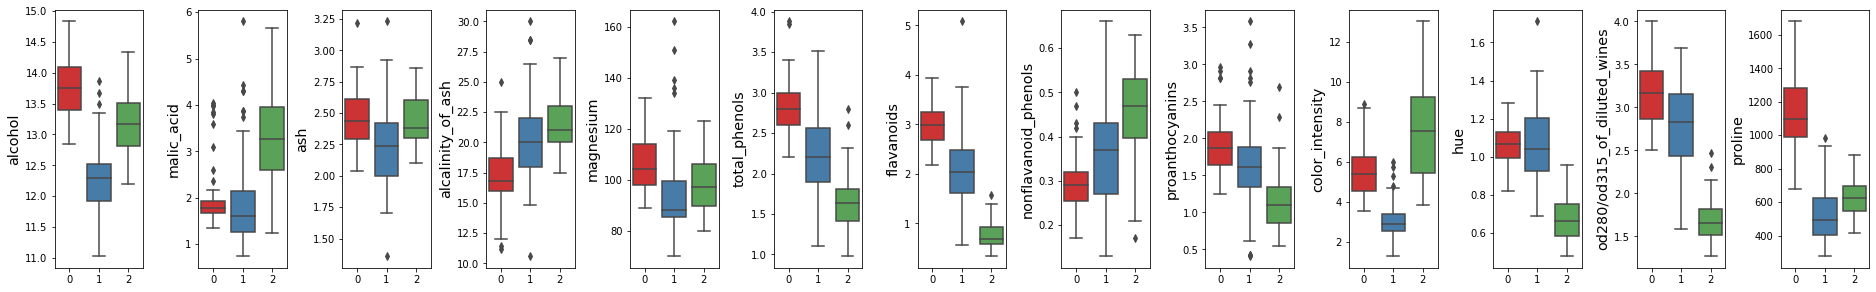

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=len(df_features.columns), figsize=(len(df_features.columns)*2,4))
for index, col in enumerate(df_features.columns):
    ax = axes[index]
#     plt.subplot(1,len(df_features.columns), index+1)
    sns.boxplot(y=df_wine.loc[:,col], x=df_wine.loc[:,'target_original'], palette=customer_palette, ax=ax)
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
#     ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_xlabel("")


plt.tight_layout(pad=0.5)
plt.show()

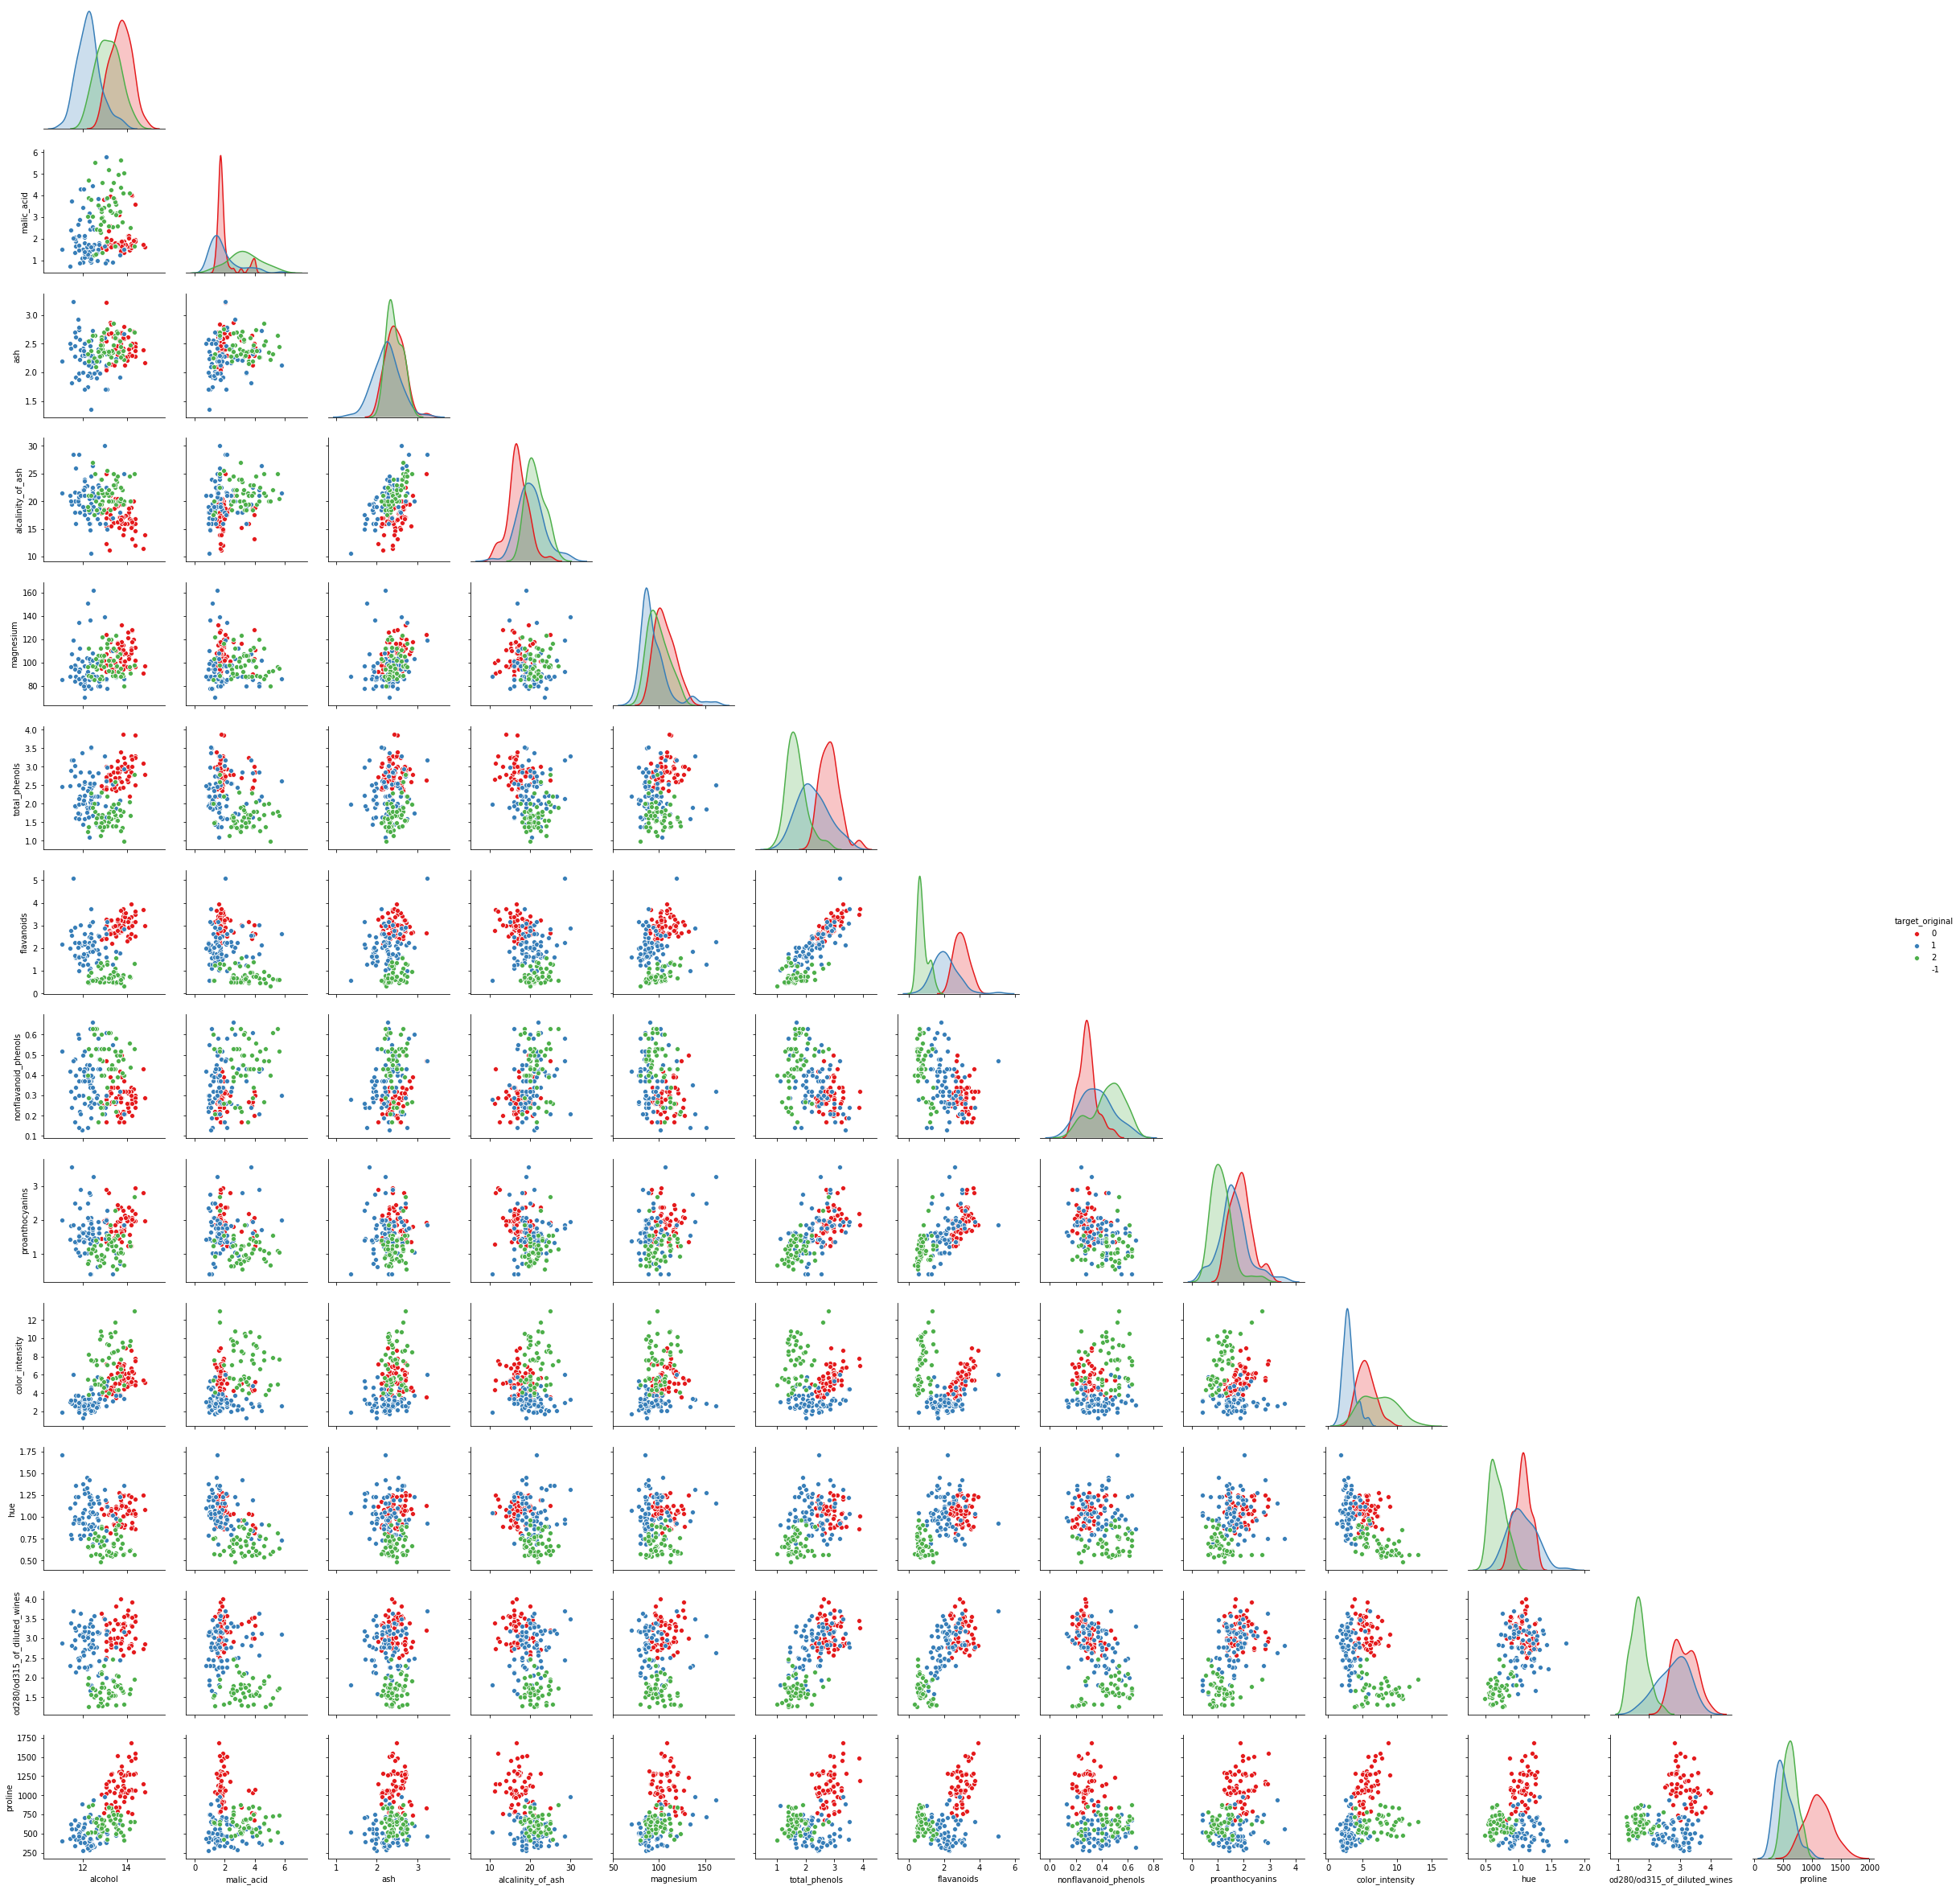

In [20]:
g = sns.pairplot(data=df_wine, vars=df_features.columns, hue='target_original',
#                  height = 1, 
            
                 corner=True, palette=customer_palette, hue_order=target_order)

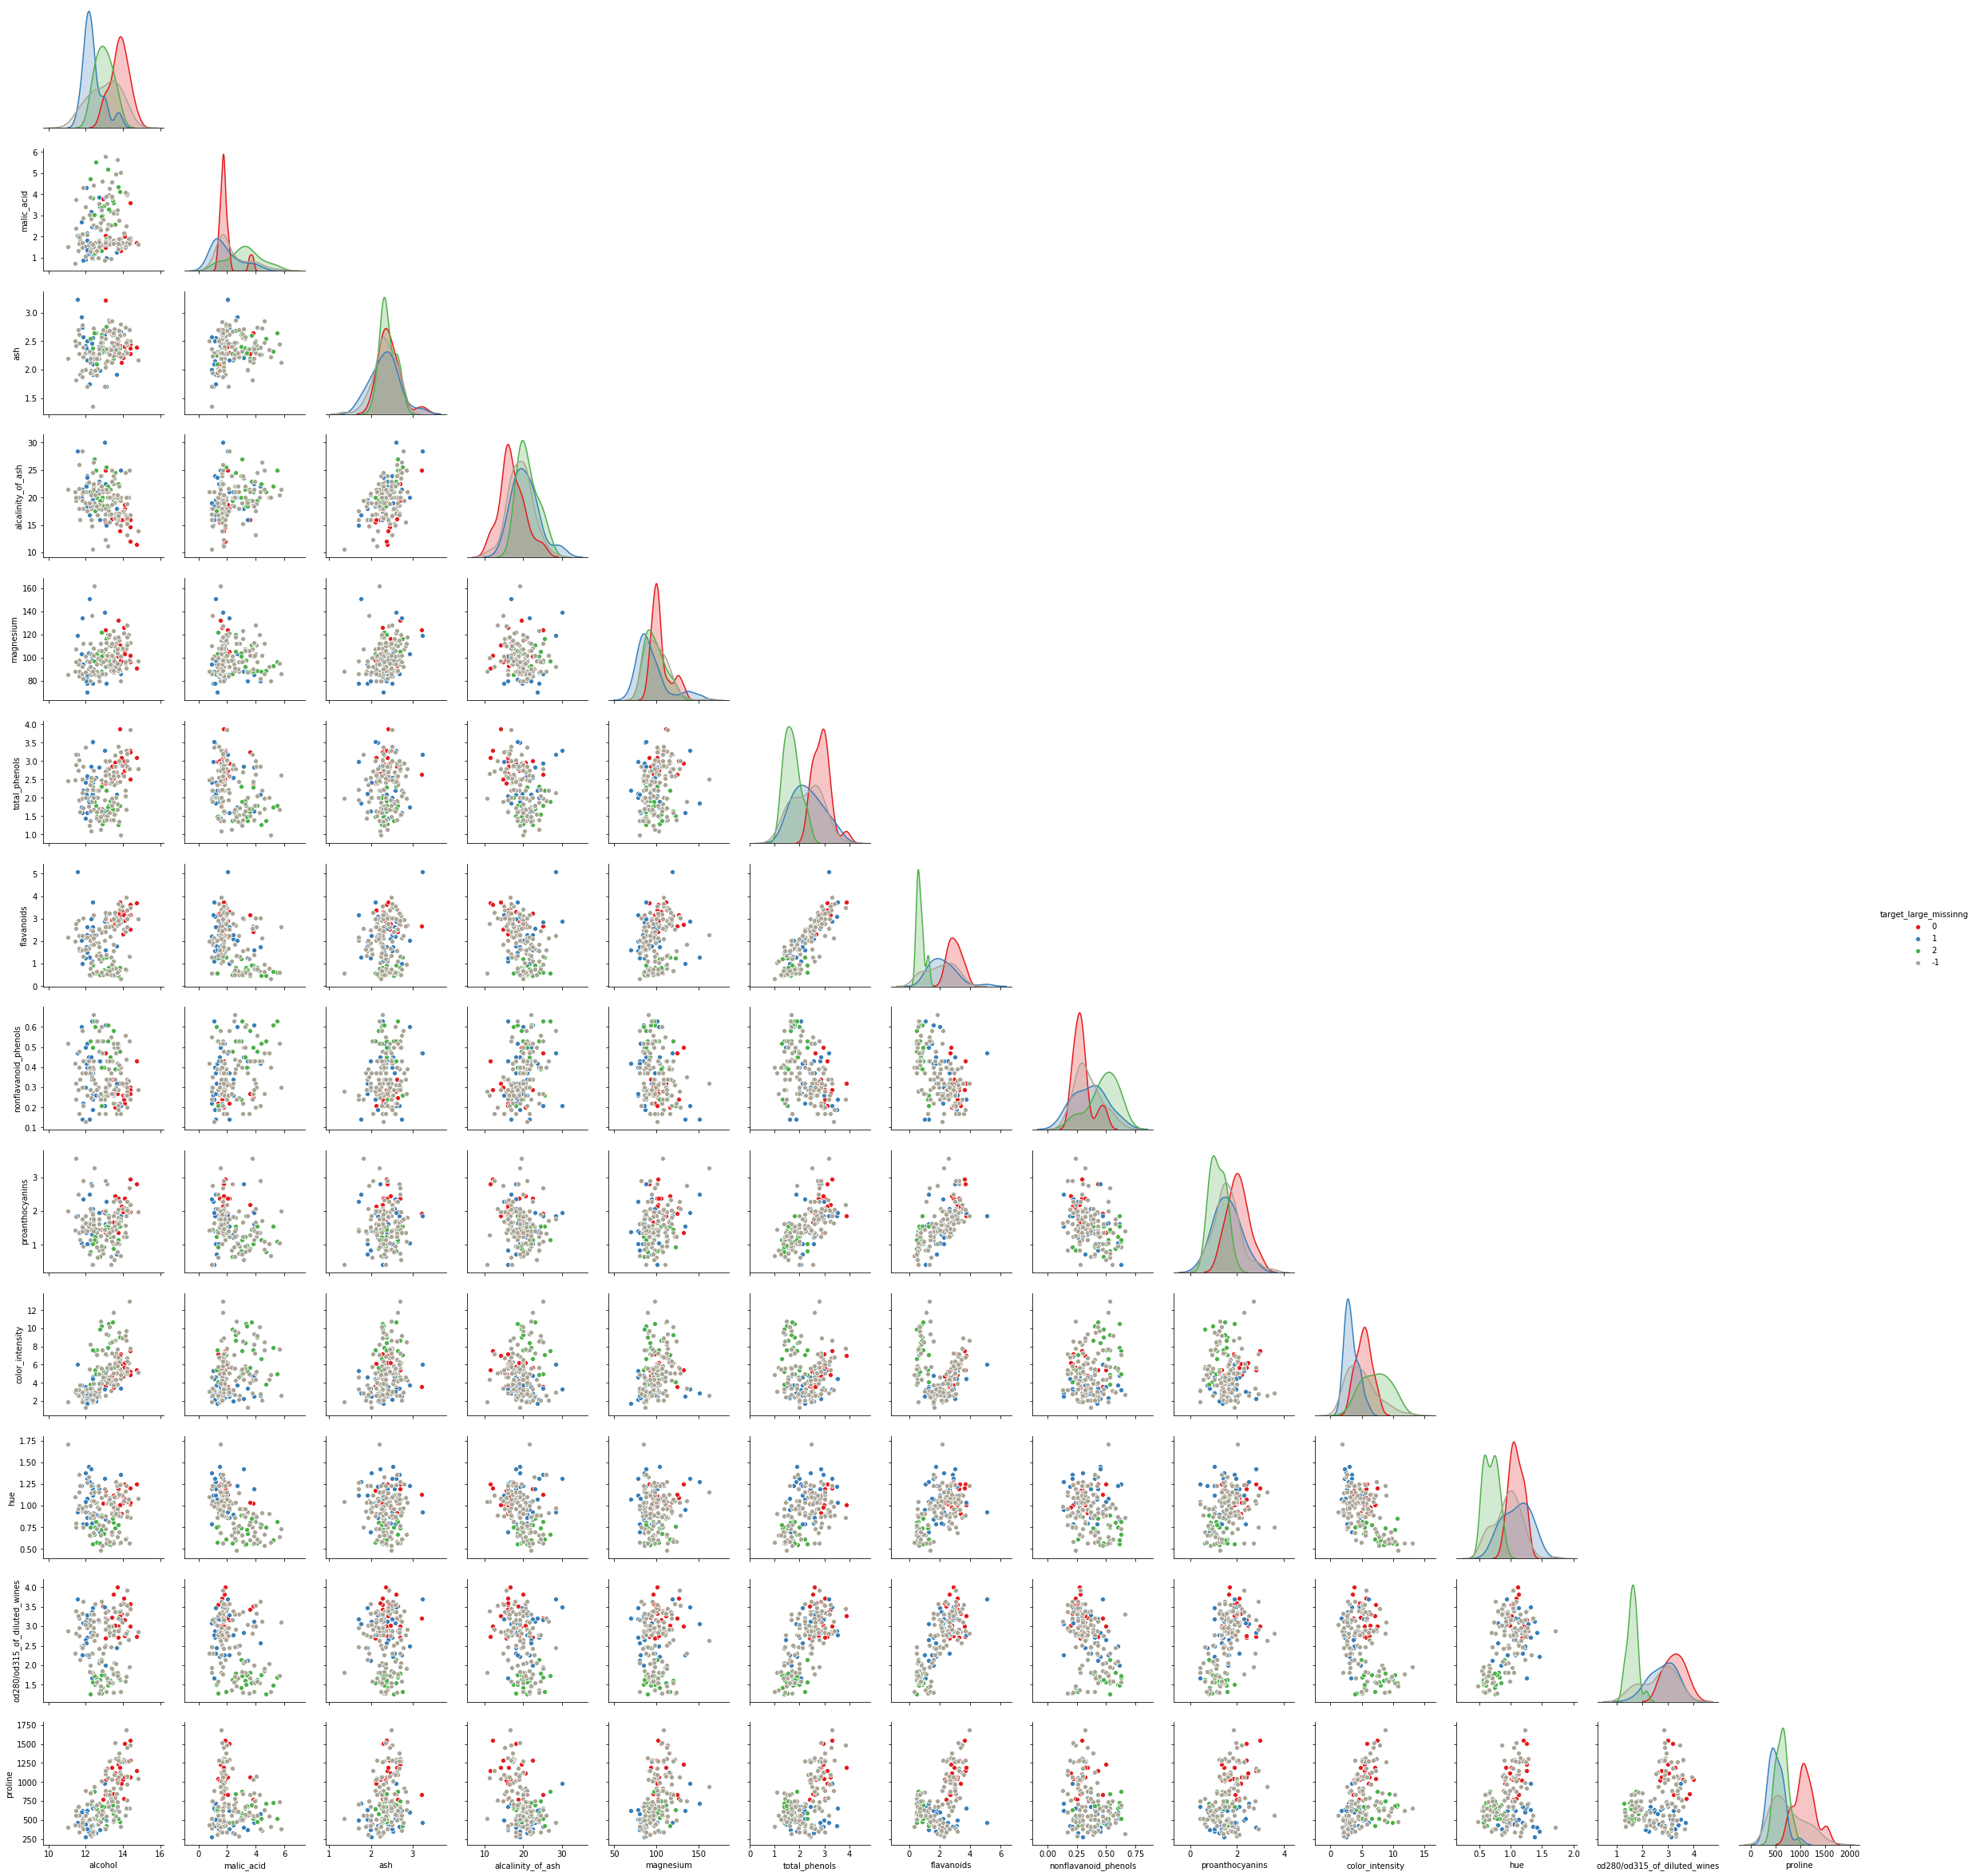

In [21]:
g = sns.pairplot(data=df_wine, vars=df_features.columns, hue='target_large_missinng', 
                 corner=True, palette=customer_palette, hue_order=target_order)

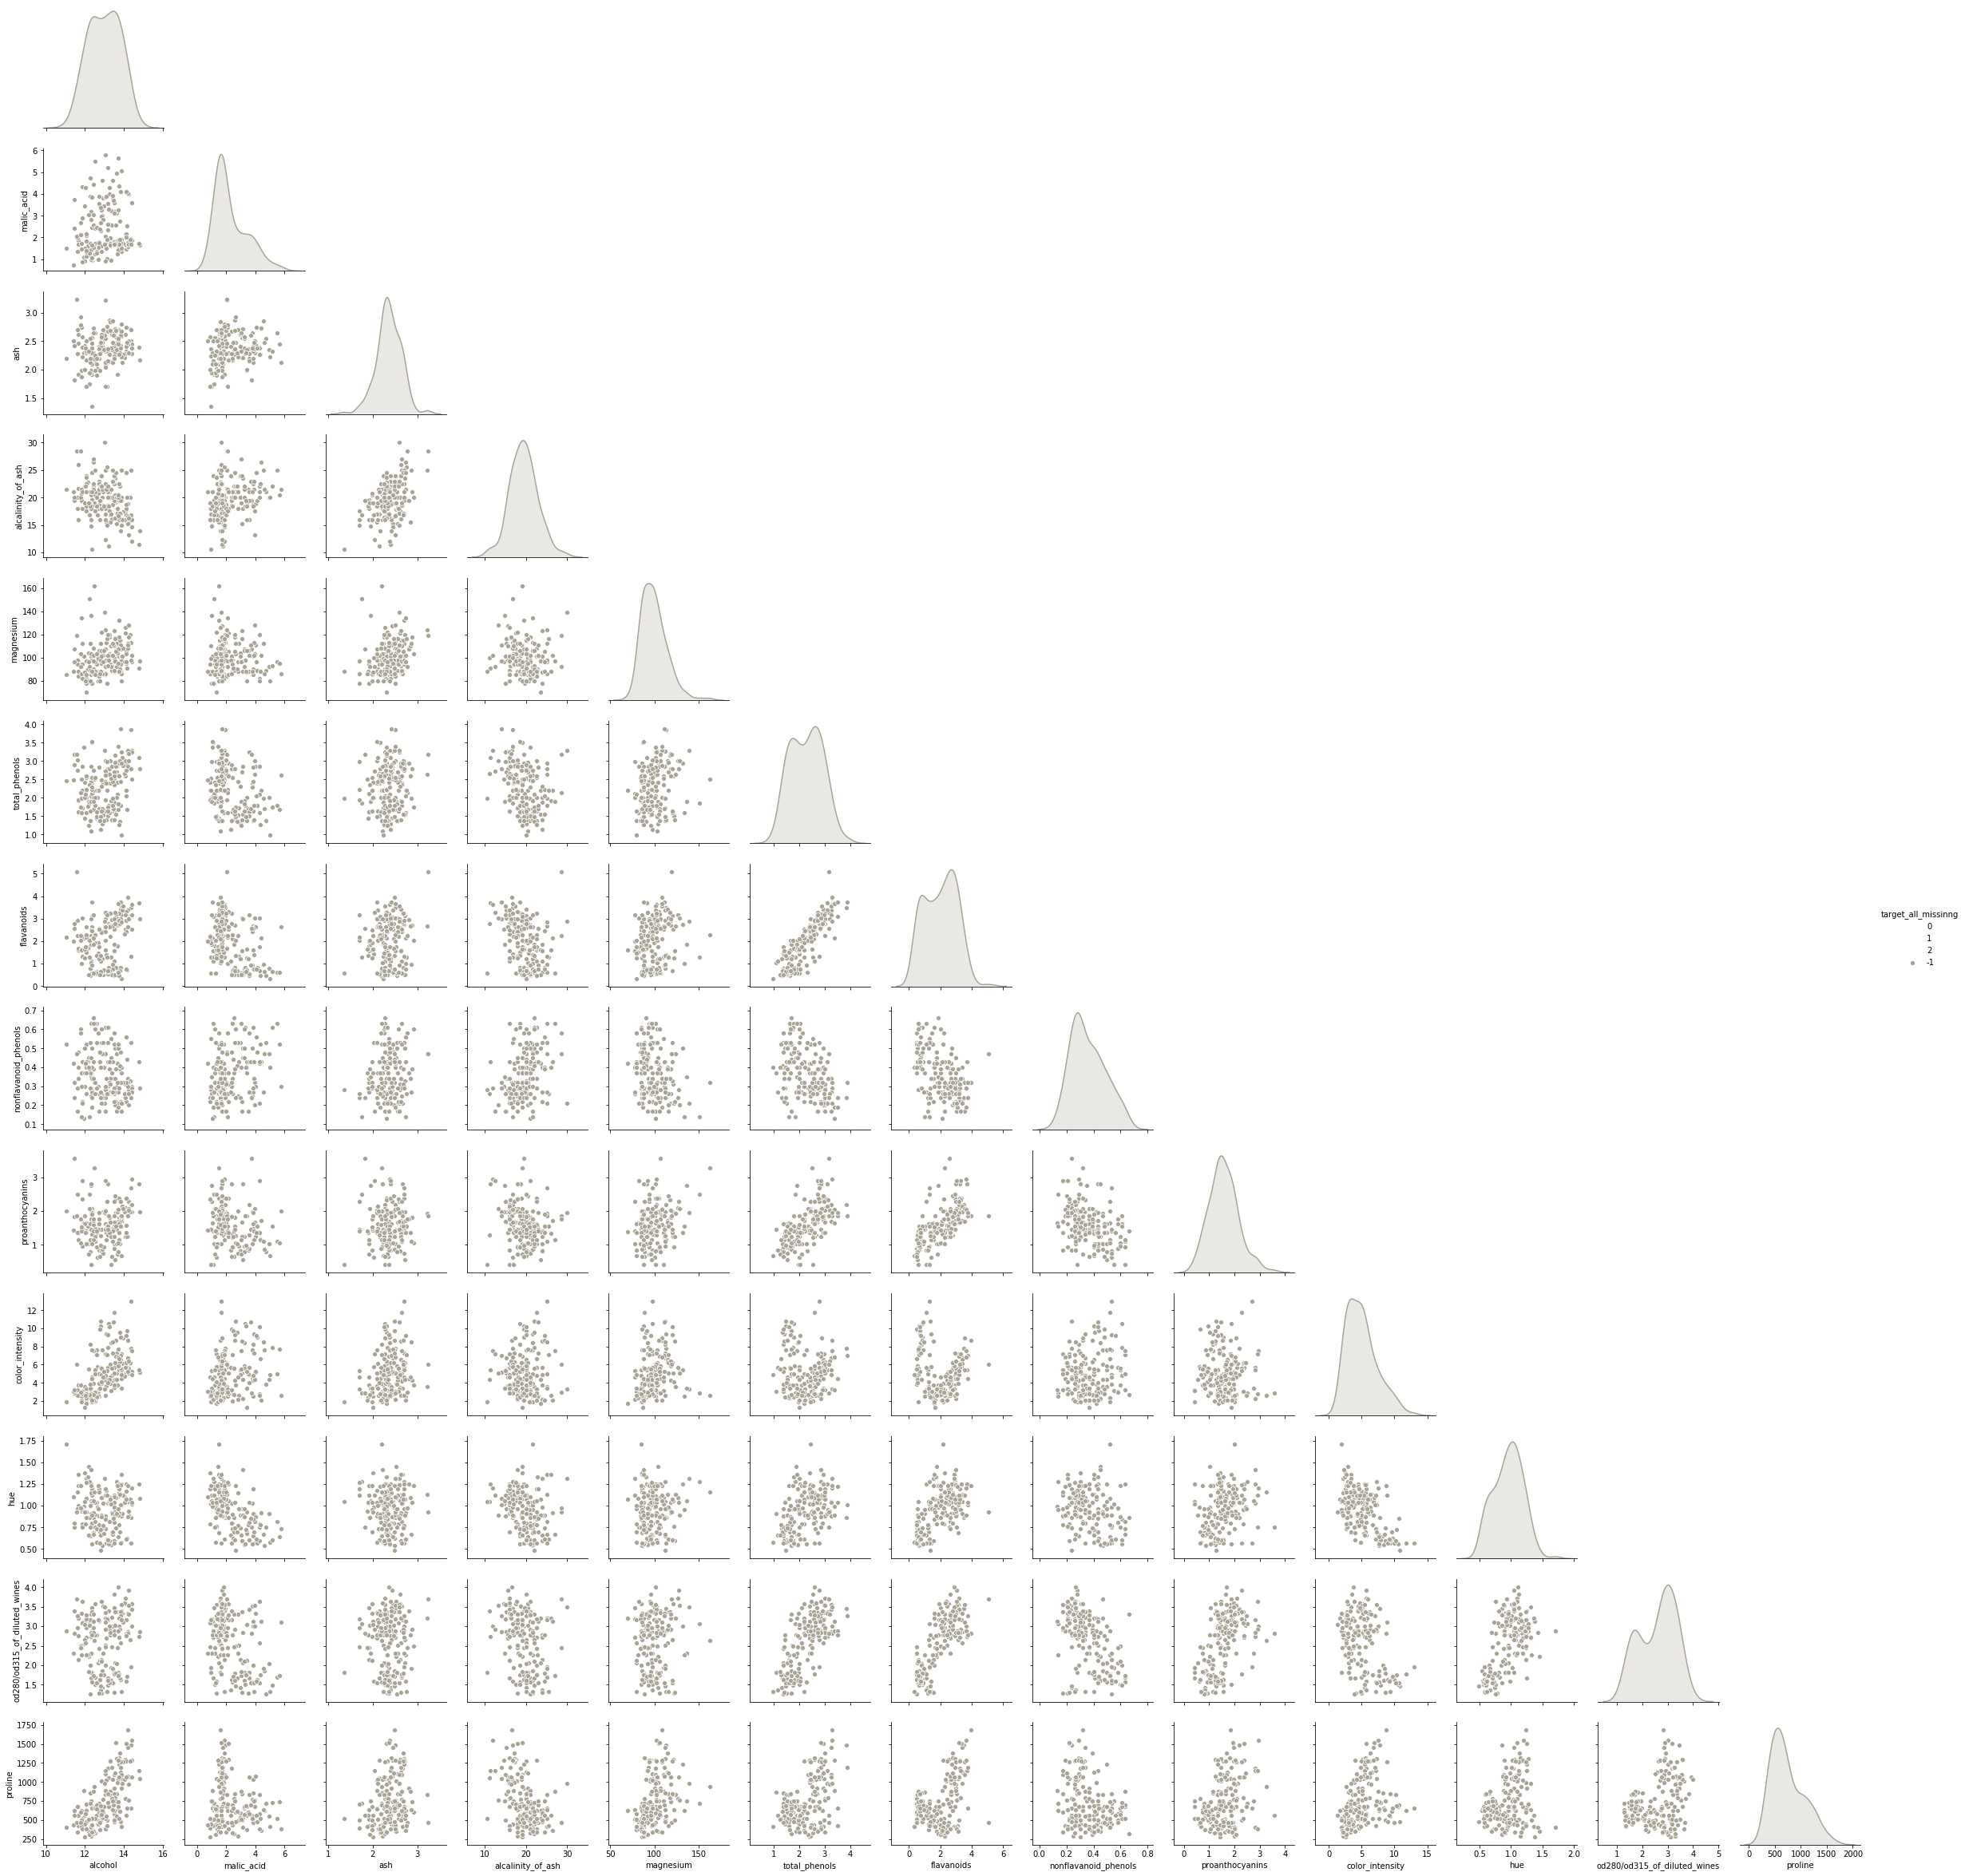

In [22]:
g = sns.pairplot(data=df_wine, vars=df_features.columns, hue='target_all_missinng', 
                 corner=True, palette=customer_palette, hue_order=target_order)

You might be wondering why visualizing the same data three times with just the different colors. So, here is the thing: We challenge the reader to distiguish three different target classes with color aid (the first pair plot), with weak color aid (the second pair plot) and no color aid (the last pair plot). 

The point here is, under the original data representation without target labels (unsupervised learning situation) or only limited amount of labels (semi-supervised learning situation), the distinction among classes is not visible to human eyes. While human may fail to see higher dimensional interaction between features, machine learning models may find some patterns. Yet why not try to represent the data in a more intelligent way by, for example, a proper scaler followed by the PCA?

### 2.3 Comparing different scalers

#### 2.3.1 First glance
Here we will transform the dataset using all 8 different scalers available in SciKit-Learn's preprocessing subclass. Note that we are not paying much attention on tuning the scalers' hyper-parmameters. We plot the scatter plots of the PCA's first two components of the transformed dataset, always keep the spirit of reducing progressively the color aid.

In [23]:
X_train = df_features.copy()
y_train = df_target

X_trans_dict, X_pca_dict,instance_pca_dict = transformer_bundle(X_train,is_get_instance=True)

C:\Users\kefei\Anaconda3\envs\blog\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (178). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


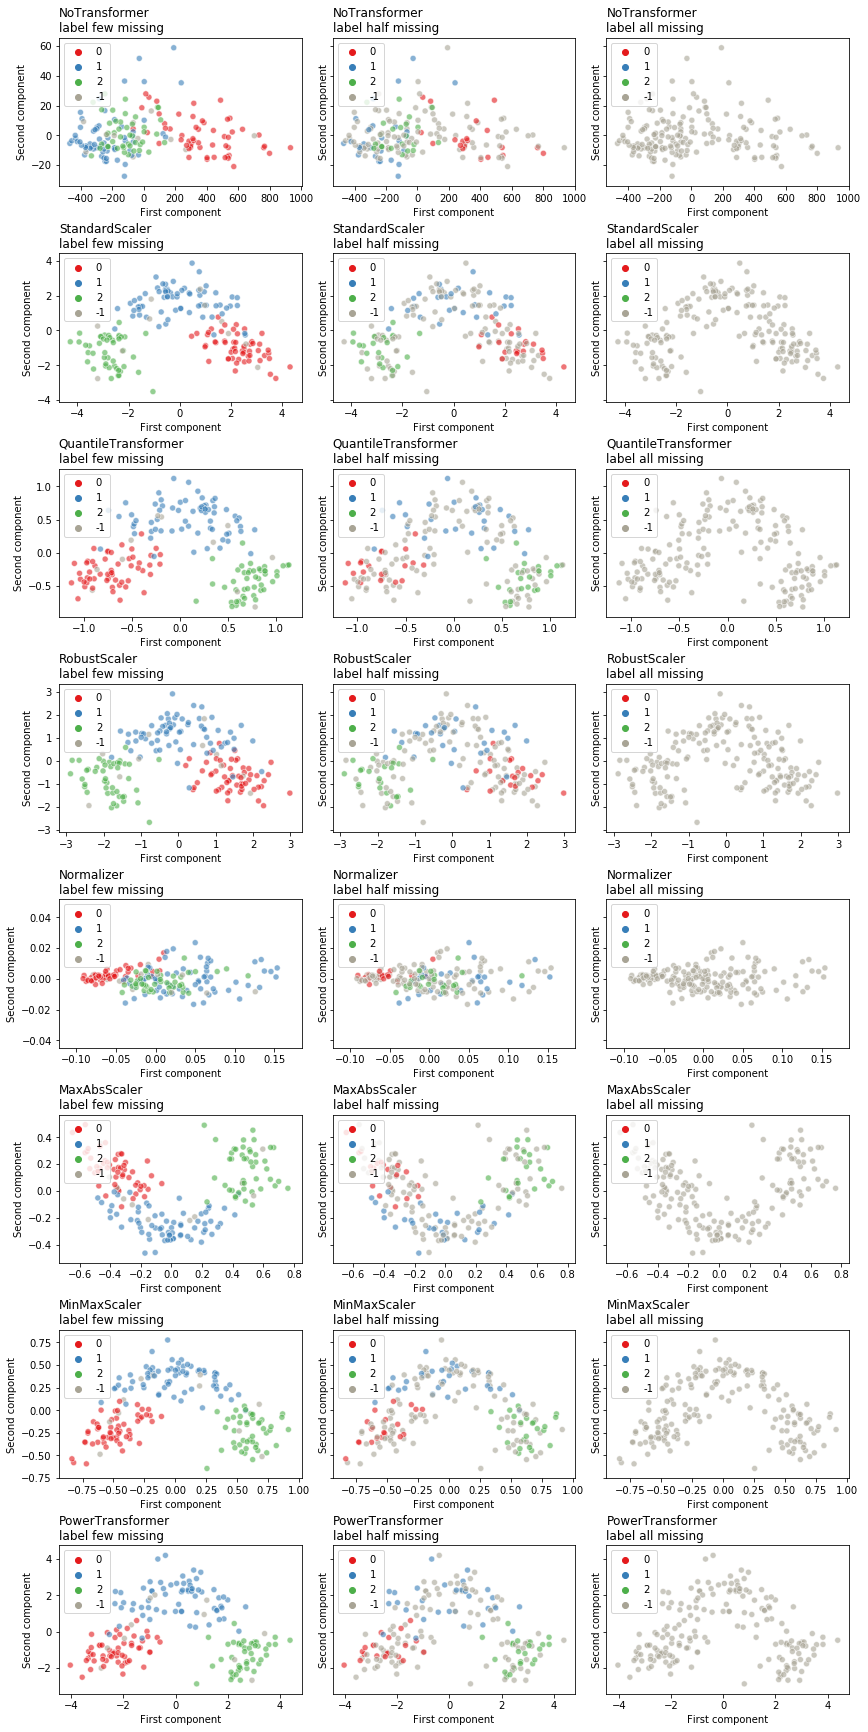

In [24]:
pca_scatter_plot(X_pca_dict, y_train.iloc[:,1:])

Don't get lost in the abundance of the scatter plots. Let's take a closer look at the ones with color aid. We'd like to conclude that, with this dataset, it's better to scale the data, no matter which scaler we choose with one exception: the normalizer, who scales data row-wise instead of column-wise (We are not sure of when such a scaler might be useful, we would love to have discussion with you the readers about when to use it). 

One of the reasons why scaled datasets make each class more distinguishable than unscaled data is that the variance of the variables is brought to a comparable level, so that the feature having the highest variance while not necessarily being the most useful one has less impact.

For readers who have the math knowledge about the PCA, here is a little exercise: the clusters of different classes don't always appear in the same order, say from left to right being red, blue and green, it can be green, blue and red. Why does such permutation phenomenon occur?

Let's move on to investigate more about PCA acting on differently scaled dataset. Below are box plots of each feature after PCA, different scalers are distinguished row-wise.

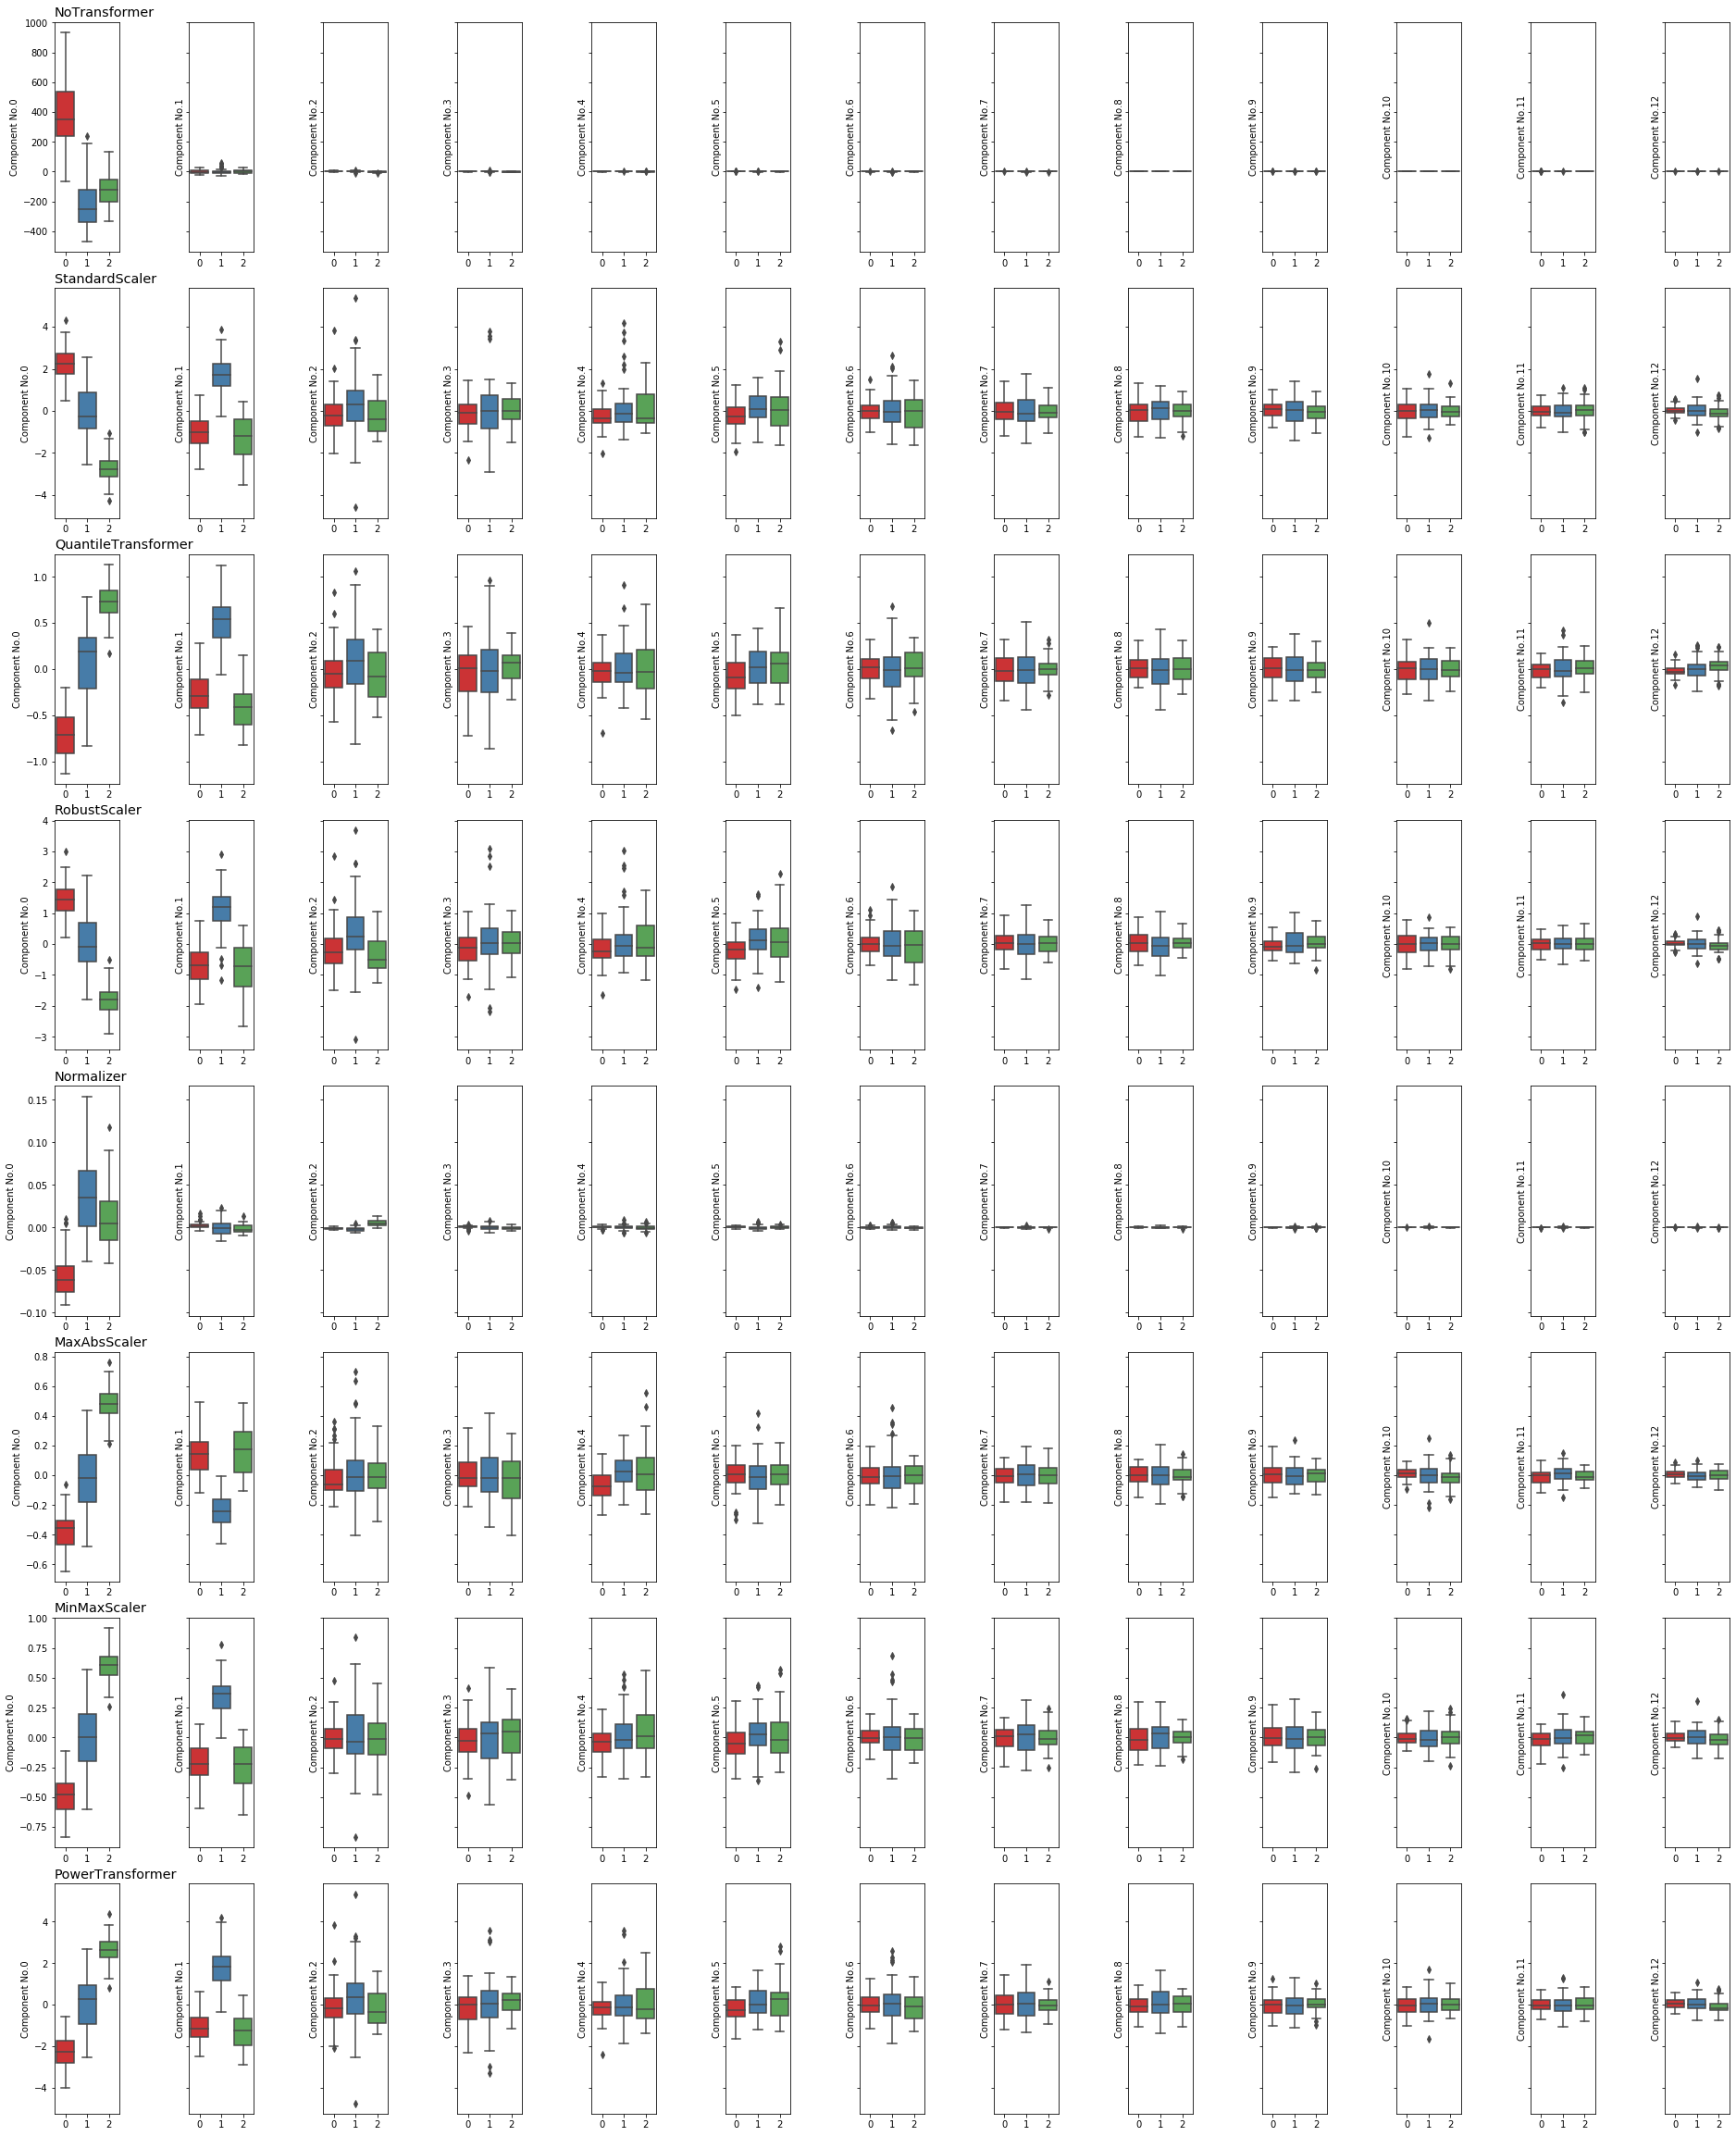

In [25]:
pca_box_plot(X_pca_dict, df_target.loc[:,'target_original'])

Again, without any transformation, almost all the interesting information concentrates on the first component, leaving little variance to the rest of the space. We would claim that the most important ingredient of the first component be "proline" from the original dataset, and indeed the behavior of the boxes is almost identical to that of the boxes ploted for "proline" using the original feature space above.

If we look at other scalers (except the normalizer), we can see the trend of boxes bouncing the less and less when going from the first component (the most informative) to the last (the least informative), and more interestingly, almost all scalers result in a cut-off effect at the third component. At this stage we may be confident enough that the first two components are representative.

We can explore even a little further to check the covariance matrices, since PCA directly works on a covariance matrix and output the principal components. That's literally the very beginning of the story.

Let's visualize the covariance matrices by Seaborn's heatmap function. 

An important note: we usually use heatmap to show Pearson correlation coefficient matrix (CC matrix), but there is a key difference between these two matrices: the values in a covariance matrix is not necessarily between (-1,1), and the values on diagonal are not always 1. That's why we plot the diagonal values even using lower triangle heatmap. Here it sufficices to look at the absolute value of the covariance matrices, so we added the absolute version right beside of each plot. 

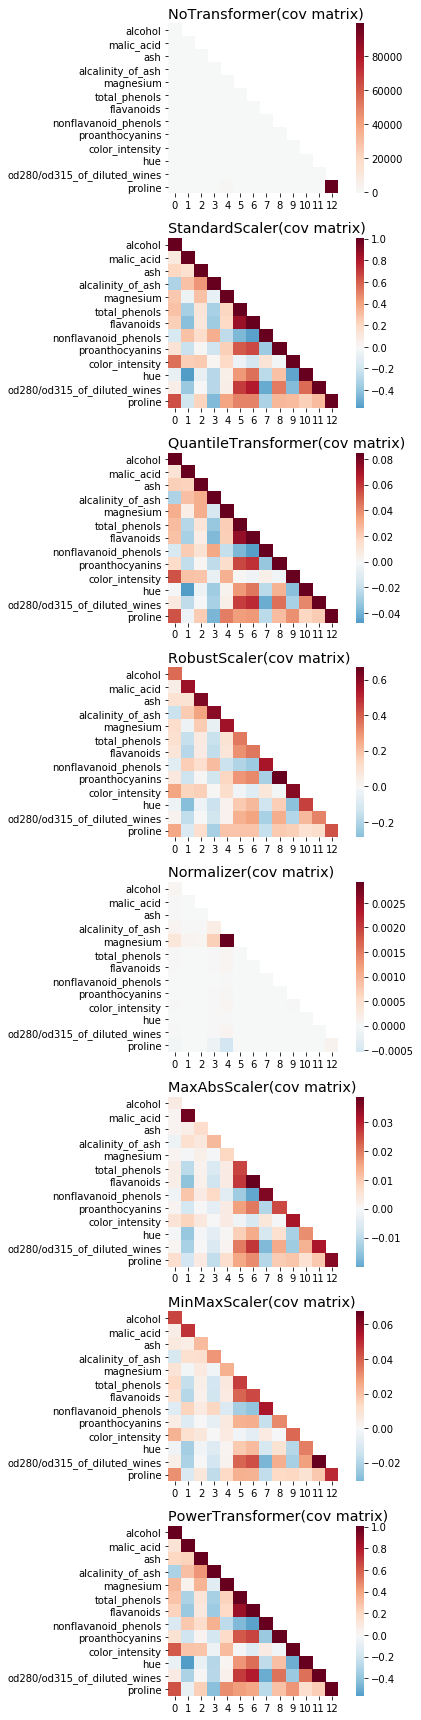

In [26]:
trans_heat_plot_abs(X_trans_dict, y_axis_labels=df_features.columns)

At this point, the heatmap might not be very intuitive comparing to the scatter plots and/or the box plots because the label information does not get into the heatmap. Also, the fine gradient of some colorbars makes some heatmaps very similar to each others.

Yet, we do have a hint from these heatmaps of how well a matrix may adapt to the PCA. A rule of thumb is, the more colorful the heatmap, the better the PCA result. Normally PCA doesn't like a plain-looking heatmap and would output less interesting principal components. In our example, since "proline" is the one that stands out, PCA will have all eyes on it. And this is consistent with our analysis earlier. Aother plain-looking one is normalizer transformed data, from the heatmap we might guess that the ONE component from PCA would be largely "magnesium", hence the dull result given by normalizer + PCA.

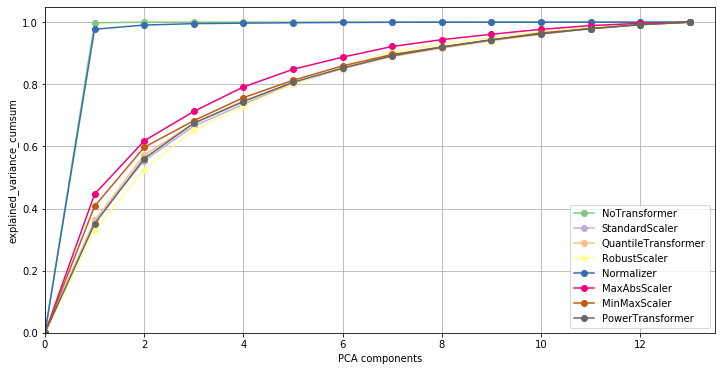

In [27]:
# plot the explained_variance cumsum using previously calculated PCA instances.
pca_plot_cumsum(instance_pca_dict)

#### 2.3.2 How do the clustering algorithms like our processed matrices?

We are more or less happy with the preprocessing results, by seeing the first 2 dimensions of the new aspect of the feature space, found by PCA. However, are the clustering algorithms, who can see higher dimensional interactions, favour the same transformed matrices as we do? Let's cluster the data using machine learning clustering models. 

One advantage we have when doing clustering tasks on labeled dataset is, we know the correct number of classes. Next we will see how well the k-means agrees with the true labels.

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, v_measure_score

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)
scores0,scores1,scores2 = [],[],[]
for trs in X_pca_dict.keys():
    X_trs = X_trans_dict[trs]
    X_PCA = X_pca_dict[trs]
        
    pred0 = kmeans.fit_predict(X_trs[:,-2:]) # we took the last two features because visually these two have shown the pattern rather clearly (cf the pairplot)
    scores0.append(v_measure_score(labels_true=y_train.target_original.values, labels_pred=pred0))
    pred1 = kmeans.fit_predict(X_PCA[:,:2])
    scores1.append(v_measure_score(labels_true=y_train.target_original.values, labels_pred=pred1))
    pred2 = kmeans.fit_predict(X_PCA)
    scores2.append(v_measure_score(labels_true=y_train.target_original.values, labels_pred=pred2))
    
df_scores = pd.DataFrame(np.array([scores0, scores1, scores2]).T, 
                         columns=['orig_2Features', 'PCA_2Features', 'allFeatures'],
                         index=X_pca_dict.keys()
                         )

In [29]:
df_scores

orig_2Features  PCA_2Features  allFeatures
StandardScaler             0.650250       0.882065     0.875894
QuantileTransformer        0.637325       0.884414     0.866171
RobustScaler               0.650250       0.745914     0.882065
Normalizer                 0.226435       0.382280     0.382280
MaxAbsScaler               0.650250       0.765960     0.756625
MinMaxScaler               0.625522       0.834659     0.841680
PowerTransformer           0.693483       0.882065     0.861514
NoTransformer              0.428757       0.428757     0.428757

In [30]:
df_scores.to_csv('cluster_score.csv')

Here we adopted the first metric for the blog: V-measure score. We would not go into the details to talk about this index, all you need to know is: <br>
V-measure score is bounded in range $[0, 1]$: values close to 0 are bad, while 1.0 stands for perfect match.

We are comparing 3 senarios: clustering with 2 original features, the 2 most informative PCA components and the total feature set. We chose 2 features or components in order to keep the consistency with the previous scatter plots. While more columns might reveal more thouroughly the dataset's information, we think that 2 dimensions, at least to begin with, are a good enough.

Let's take a closer look at the above table.<br>
**Firstly**, if we focus on the last column which contains V-measure scores using the entire dataset, with or without scaling, we can see that it's always better to scale the data, no matter which scaler we choose, except the Normalizer.<br>
**Secondly**, staying in the original aspect of the feature space, it's always better to use the entire dataset, instead of choosing a subset of features that "seems" to illustrate better the clusters (comparaison between the first and the third columns). On the other hand, when staring at the same data from the new aspect given by PCA, it sometimes results more reasonable clusters with merely a few of the components than using all of them (comparaison between the second and the third columns). Even though in some of the tests the first-2-component choice does not outperform the totality, there is a close match in terms of V-measure score between the two choices, however the calculation sources are uncomparable (2-column matices vs 13-column matrices).<br>
**And lastly**, looking at the second column, we find that the most suitable scalers for this single task are the two non-linear ones plus the standard scaler. For this reason, the reader might want to try out more scalers by doing simple tests like what we have done in this blog, before applying directly the most commonly used standard scaler.

We'd like to have a few more words on the less-is-more phenomenon shown by PCA.  It's often argued that throwing away information from the original dataset is not a wise choice, it is sometimes very dangerous to do so. Yet PCA reveals the most important patterns inside the data matrix while filtering out some details, and such details could be nothing but noise. So taking the first several PCA components not only helps to reduce the dimensionality, but also smoothens the information and thus makes things clearer.

To put an end to this blog, let's try to visualizae the k-means predicted cluster comparing to the actual label. Hopefully this one will give you a more tangible feeling than the clustering evaluation metric.

('X' label is a bit disturbing, we might come up with better visulization later. i.e. add a new column to inicate mis_match, then use style to control that)

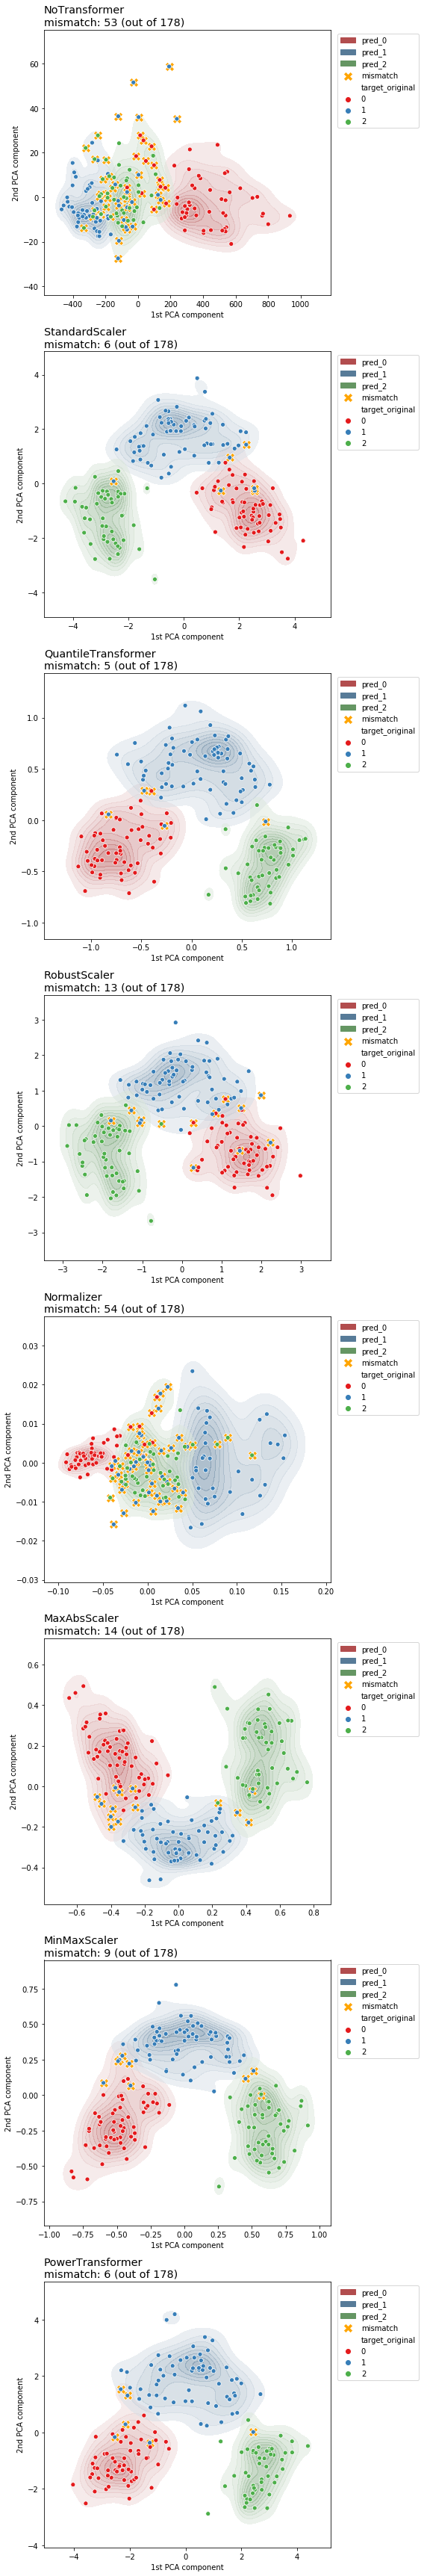

In [93]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)

pca_cluster_contour_plot(X_pca_dict,y_train, kmeans)

## 3. Summary

We have compared results of PCA acting on differently scaled data by showing the scatter plots. Visually we can see that the combinasion does carve the pattern of the dataset clearer than no preprocessing. The take-away would be, before applying PCA, always check the variance of each feature in the dataset, and if there is large gap between the variances, scale the data with a proper scaler. Depending on your task, the definition of "proper" can vary.

The next time, we will be stretching the limits of this scaler + PCA combinasion, by bringing in synthetic outliers and categorical features.